# 3_EDA: Shipping Cost Predictor

In [135]:
# Imports
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from io import StringIO
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [136]:
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [137]:
# Load variables from .env file, ignoring lines without '='
def load_env_variables(env_file='../.env'):
    # Get the current working directory
    current_dir = os.getcwd()
    env_path = os.path.join(current_dir, '..', env_file)
    
    print(f"Looking for .env file at: {env_path}")  # Debugging output

    if not os.path.exists(env_path):
        print(f".env file does not exist at: {env_path}")
        return

    with open(env_path, 'r') as file:
        for line in file:
            # Skip lines without an equals sign or comments
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value
                print(f"Loaded {key}={value}")  # Debugging output

# Load environment variables
load_env_variables()

Looking for .env file at: c:\repos\ai-logistics\notebooks\ShipCostPredictor\..\../.env
Loaded BUCKET_NAME_INBOUND=logimo-inbound
Loaded BUCKET_NAME_ALIGNED=logimo-aligned
Loaded BUCKET_NAME_OUTBOUND=logimo-outbound
Loaded PREFIX_KEY=ship_cost_predictor/


In [138]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify the bucket name and prefix (folder path)
bucket_name = os.getenv('BUCKET_NAME_ALIGNED')
prefix = os.getenv('PREFIX_KEY')

# List objects in the specified S3 folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Initialize a list to store CSV file keys
csv_files = []

# Iterate over the objects and collect keys of CSV files
for obj in response.get('Contents', []):
    object_key = obj['Key']
    if object_key.endswith('.csv'):
        csv_files.append(object_key)

In [139]:
csv_files

['ship_cost_predictor/Sample_Data_Product_Cleaned.csv',
 'ship_cost_predictor/Sample_Data_Product_Concatenated.csv']

In [140]:
# Fetch the content of the second CSV file from S3
obj = s3.get_object(Bucket=bucket_name, Key=csv_files[0])

# Read the content of the CSV file
csv_content = obj['Body'].read().decode('utf-8')

# Use pandas to read the CSV content into a DataFrame
supply_chain_df_cleaned = pd.read_csv(StringIO(csv_content))

---

### Basic data exploration

In [141]:
# Data glance
supply_chain_df_cleaned.head()

,product_type,sku,estimated_price,availability,number_of_products_sold,revenue_generated,customer_demographics,stock_levels,lead_times,order_quantities,...,lead_time,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates,transportation_modes,routes,costs,demurrage
0,cosmetics,062000007,22790.0,17.0,715.0,8656.12,Non-binary,58.0,24.0,79.0,...,16.0,168.0,21.0,71.42,Pending,3.35,Rail,Route_B,407.65,0.0
1,cosmetics,1VBA0260GE,53970.0,78.0,949.0,4516.14,Unknown,75.0,15.0,90.0,...,3.0,617.0,28.0,80.63,Pass,4.66,Rail,Route_A,424.80,1633889.0
2,skincare,1VBF0810GE,80180.0,44.0,687.0,6449.54,Male,97.0,20.0,10.0,...,13.0,306.0,17.0,65.34,Pending,0.61,Air,Route_B,603.41,0.0
3,skincare,1VMG0080GE,62870.0,46.0,903.0,1755.28,Female,18.0,21.0,98.0,...,20.0,486.0,29.0,29.09,Fail,3.09,Rail,Route_C,331.07,0.0
4,skincare,1VMG0140GE,83820.0,99.0,163.0,7097.87,Non-binary,88.0,18.0,50.0,...,23.0,941.0,17.0,97.18,Pending,2.58,Road,Route_B,392.25,0.0


In [142]:
# Dataset info
supply_chain_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_type             1640 non-null   object 
 1   sku                      1640 non-null   object 
 2   estimated_price          1640 non-null   float64
 3   availability             1640 non-null   float64
 4   number_of_products_sold  1640 non-null   float64
 5   revenue_generated        1640 non-null   float64
 6   customer_demographics    1640 non-null   object 
 7   stock_levels             1640 non-null   float64
 8   lead_times               1640 non-null   float64
 9   order_quantities         1640 non-null   float64
 10  shipping_times           1640 non-null   float64
 11  shipping_carriers        1640 non-null   object 
 12  shipping_costs           1640 non-null   float64
 13  supplier_name            1640 non-null   object 
 14  location                

---

### Dataset description

In [143]:
# Dataset info
supply_chain_df_cleaned.describe()

,estimated_price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,production_volumes,manufacturing_lead_time,manufacturing_costs,defect_rates,costs,demurrage
count,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1.640000e+03
mean,50817.890244,50.868902,508.412805,5588.976409,49.857317,14.736585,49.860976,5.040854,549.167073,14.963415,533.719512,15.184146,55.442963,2.515506,548.734707,5.458774e+05
std,28336.260812,28.628683,285.275628,2557.628607,28.882529,8.332702,28.000352,2.563919,255.803886,8.318177,260.252418,8.226076,25.979000,1.442442,258.641141,7.840692e+05
min,1010.000000,1.000000,1.000000,1016.190000,1.000000,1.000000,1.000000,1.000000,101.000000,1.000000,100.000000,1.000000,10.000000,0.000000,100.770000,0.000000e+00
25%,26017.500000,26.000000,263.000000,3434.542500,24.000000,7.000000,26.000000,3.000000,322.000000,8.000000,307.750000,8.000000,32.740000,1.290000,323.835000,0.000000e+00
50%,51340.000000,51.000000,516.500000,5648.785000,51.000000,15.000000,50.000000,5.000000,542.500000,15.000000,525.000000,15.000000,55.770000,2.515000,555.515000,0.000000e+00
75%,75067.500000,75.000000,755.250000,7730.930000,75.000000,22.000000,74.250000,7.000000,768.250000,22.000000,762.000000,22.000000,77.985000,3.790000,765.945000,1.107884e+06
max,99990.000000,99.000000,999.000000,9994.800000,99.000000,29.000000,99.000000,9.000000,1000.000000,29.000000,999.000000,29.000000,99.880000,5.000000,998.960000,2.499548e+06


| **Variable Name**          | **Description**                                    | **Type of Data** |
|----------------------------|----------------------------------------------------|------------------|
| Product type               | Type of product                                    | Object           |
| SKU                        | Stock Keeping Unit                                 | Object           |
| Estimated Price            | Price of the product                               | Float            |
| Availability               | Availability status of the product                 | Float            |
| Number of products sold    | Number of products sold                            | Float            |
| Revenue generated          | Total revenue generated                            | Float            |
| Customer demographics      | Demographic details of the customers               | Object           |
| Stock levels               | Current stock levels                               | Float            |
| Lead times                 | Time taken from order to delivery                  | Float            |
| Order quantities           | Quantities ordered                                 | Float            |
| Shipping times             | Time taken for shipping                            | Float            |
| Shipping carriers          | Carriers used for shipping                         | Object           |
| Shipping costs             | Cost incurred for shipping                         | Float            |
| Supplier name              | Name of the supplier                               | Object           |
| Location                   | Location of the supplier                           | Object           |
| Lead time                  | Time taken by supplier to fulfill orders           | Float            |
| Production volumes         | Volume of products produced                        | Float            |
| Manufacturing lead time    | Time taken for manufacturing                       | Float            |
| Manufacturing costs        | Costs involved in manufacturing                    | Float            |
| Inspection results         | Results from product inspections                   | Object           |
| Defect rates               | Rates of defects found in products                 | Float            |
| Transportation modes       | Modes of transportation used                       | Object           |
| Routes                     | Routes used for transportation                     | Object           |
| Costs                      | Overall costs                                      | Float            |
| Demurrage                  | Cost incurred when sku faces demurrage             | Float            |


In [144]:
# Dataframe for variable analysis
supply_chain_eda_df = supply_chain_df_cleaned.copy()

---

### Univariate Analysis

In the following section, we will do an analysis per each variable to analyze their distribution, values and other statistical data we can obtain by this analysis.

**Numerical columns** : 

[

    'Estimated Price',
    'Availability',
    'Number of products sold',
    'Revenue generated',
    'Stock levels',
    'Lead times',
    'Order quantities',
    'Shipping times',
    'Shipping costs',
    'Lead time',
    'Production volumes',
    'Manufacturing lead time',
    'Manufacturing costs',
    'Defect rates',
    'Costs',
    'Demurrage'
]

---

In [215]:
demurrage_series = supply_chain_eda_df['demurrage']
filtered_demurrage = demurrage_series.loc[demurrage_series != 0]

In [216]:
filtered_demurrage.describe()

count    6.440000e+02
mean     1.390123e+06
std      6.257786e+05
min      3.057360e+05
25%      8.359080e+05
50%      1.408837e+06
75%      1.904268e+06
max      2.499548e+06
Name: demurrage, dtype: float64

In [217]:
print(f'Number of unique values: {len(supply_chain_eda_df["demurrage"].unique())}')
print(supply_chain_eda_df["demurrage"].unique())

Number of unique values: 644
[      0. 1633889.  777408. 1568905. 2383912. 1903735. 1890543. 1412211.
 1554304. 1699192. 1407009.  781396. 2494483. 2419575. 2069068. 1188130.
  899064. 1360134. 1942927. 1881581. 2403081.  848831. 1057339. 1860095.
 1303440. 2300715. 1347587. 2195706. 2114400. 2090034. 1019786. 1731357.
 2078735. 1017296. 1397174. 1497312. 1234699. 2340109. 1577048. 1881746.
 1330565. 1825786. 1973817.  428212. 1154336. 1007675. 1853992. 1437042.
  775463. 1237783. 1882821. 1663232. 1963262. 1962603. 1354652.  851395.
 1044572. 1802754.  380227. 1821399. 2320236. 1201802.  723987. 1814845.
 2024086. 1395813. 1859052.  760326.  607860. 1215884. 2286999. 1885507.
  829831.  360002. 1394727. 1228584. 2143775.  305736.  387295.  309845.
  698669.  366304.  463160. 1037019. 1343765. 1014145. 1858072. 1115013.
 1168037. 1249980. 1245672. 1740191.  328804. 1786945. 2180451. 1448725.
  753740. 1830497.  941127.  316180. 1611618.  705334.  423801.  316440.
  316941. 1274546. 160

In [218]:
# Setting style for plots
sns.set_theme(style="whitegrid")

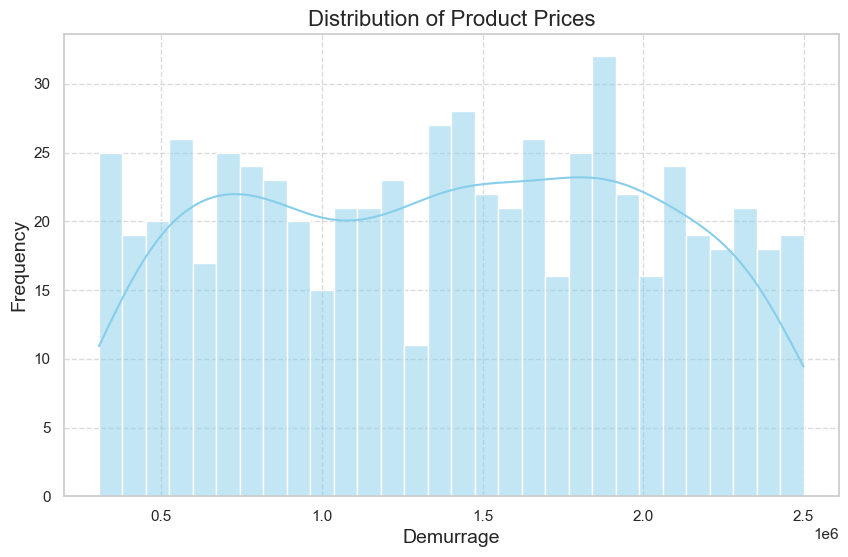

In [220]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_demurrage, bins=30, kde=True, color='skyblue')

plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Demurrage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Interpretation:

The dataset has a fairly wide range, from 305,736 to 2,499,548, indicating significant variability.
The median (1,408,837) is slightly higher than the mean (1,390,123), suggesting a slightly right-skewed distribution.
The interquartile range (75% - 25%) is 1,068,360, highlighting the spread of the middle 50% of the data.
With a substantial standard deviation, the data points are quite spread out around the mean, indicating diverse values.

---

`Estimated Price`

In [145]:
supply_chain_eda_df['estimated_price'].describe()

count     1640.000000
mean     50817.890244
std      28336.260812
min       1010.000000
25%      26017.500000
50%      51340.000000
75%      75067.500000
max      99990.000000
Name: estimated_price, dtype: float64

- **Mean (Average Price):** The average price is approximately 50.97 units, indicating that products are moderately priced around this central value.
- **Standard Deviation (Variability):** The standard deviation is 28.35 units, showing significant variability in product prices.
- **Minimum Price:** The lowest price is 1.01 units, suggesting the presence of budget-friendly options within the product range.
- **25th Percentile (Q1):** 25% of products are priced at 26.04 units or less, highlighting that a significant portion of products are relatively low-priced.
- **Median (50th Percentile):** The median price is 51.37 units, meaning half the products are priced below and half above this value, indicating a relatively symmetric price distribution.
- **75th Percentile (Q3):** 75% of products are priced at 75.40 units or less, showing that most products fall below this price, with only a quarter being more expensive.

In [146]:
print(f'Number of unique values: {len(supply_chain_eda_df["estimated_price"].unique())}')
print(supply_chain_eda_df["estimated_price"].unique())

Number of unique values: 1510
[22790. 53970. 80180. ... 89580. 27120. 64560.]


In [147]:
# Setting style for plots
sns.set_theme(style="whitegrid")

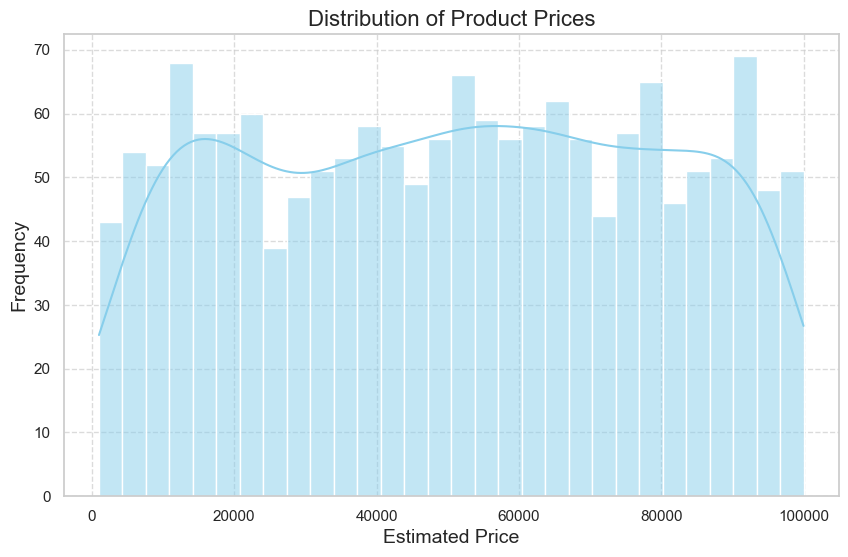

In [148]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['estimated_price'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Estimated Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

- The distribution of product prices is bimodal, with peaks around 10K-20K dollars and 50K-60K dollars.
- Prices significantly taper off after 60K dollars, suggesting fewer higher-priced products.
- The range between 20K and 45K dollars shows a noticeable dip in product frequency.
- A slight uptick in frequency occurs near the 100K dollar mark.
- Most products are priced under 60K dollars, highlighting a concentration of more affordable options in the dataset.

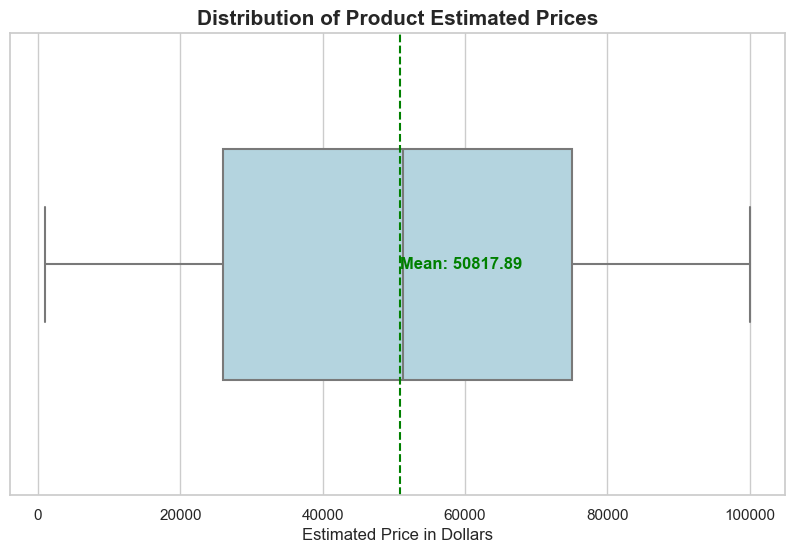

In [149]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['estimated_price'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Product Estimated Prices', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Estimated Price in Dollars', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['estimated_price'].mean()
plt.axvline(mean_price, color='green', linestyle='--') 
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

# Show the plot
plt.show()

- The mean price of the products is approximately 50.97K dollars.
- Prices are symmetrically distributed around the mean.
- Prices range from near 0 to almost 100K dollars.
- The middle 50% of prices (Interquartile Range) spans from about 25K to 75K dollars.
- There are no outliers in the data.
- The lowest prices are close to 0 dollars, and the highest prices approach 100K dollars.

---

`availability`

In [150]:
supply_chain_eda_df['availability'].describe()

count    1640.000000
mean       50.868902
std        28.628683
min         1.000000
25%        26.000000
50%        51.000000
75%        75.000000
max        99.000000
Name: availability, dtype: float64

- The average availability is approximately 50.64 units.
- Availability varies widely, with a standard deviation of 28.57 units.
- The minimum availability recorded is 1 unit.
- 25% of the data points have availability less than or equal to 26 units.
- The median availability is 51 units, indicating that half of the products have availability less than or equal to this value.
- 75% of the data points have availability less than or equal to 75 units.
- The maximum availability recorded is 99 units.

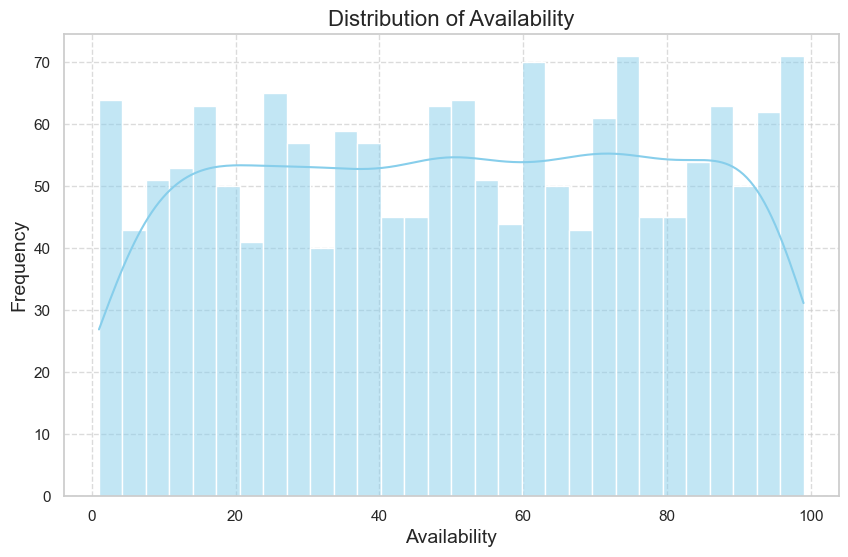

In [151]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['availability'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Availability', fontsize=16)
plt.xlabel('Availability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

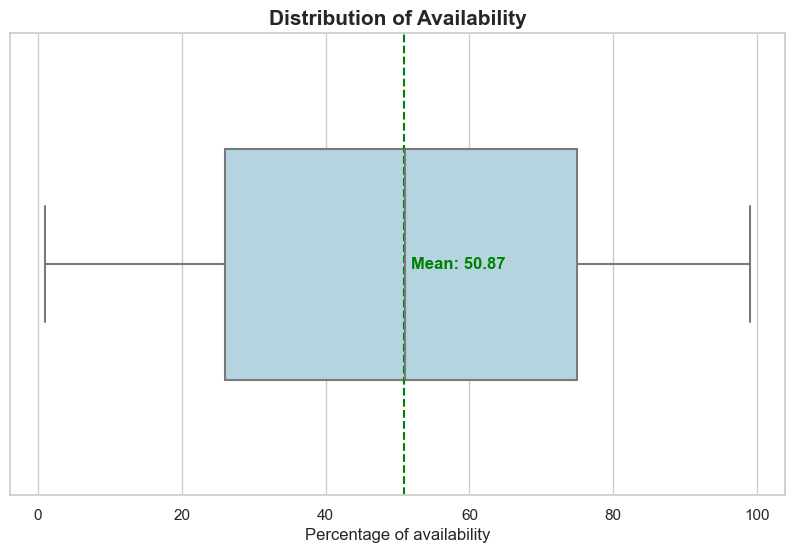

In [152]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['availability'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Availability', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Percentage of availability', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['availability'].mean()
plt.axvline(mean_price, color='green', linestyle='--') 
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Number of products sold`

In [153]:
supply_chain_eda_df['number_of_products_sold'].describe()

count    1640.000000
mean      508.412805
std       285.275628
min         1.000000
25%       263.000000
50%       516.500000
75%       755.250000
max       999.000000
Name: number_of_products_sold, dtype: float64

- The average number of products sold is approximately 508.30 units.
- There is high variability in the number of products sold, with a standard deviation of about 285.99 units.
- The minimum number of products sold is 1 unit.
- 25% of the products have sold 263 units or fewer.
- The median number of products sold is 516 units, meaning half of the products sold fewer than this number.
- 75% of the products have sold 756 units or fewer.
- The maximum number of products sold is 999 units.

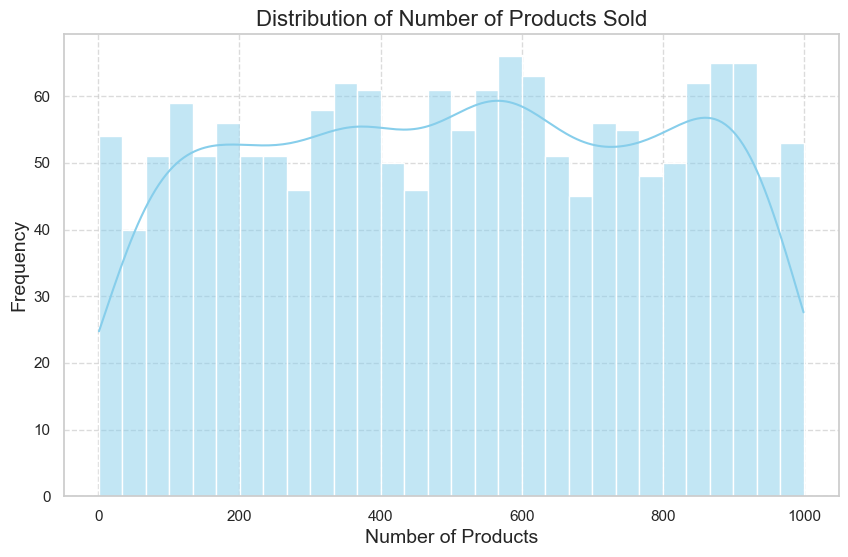

In [154]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['number_of_products_sold'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Number of Products Sold', fontsize=16)
plt.xlabel('Number of Products', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

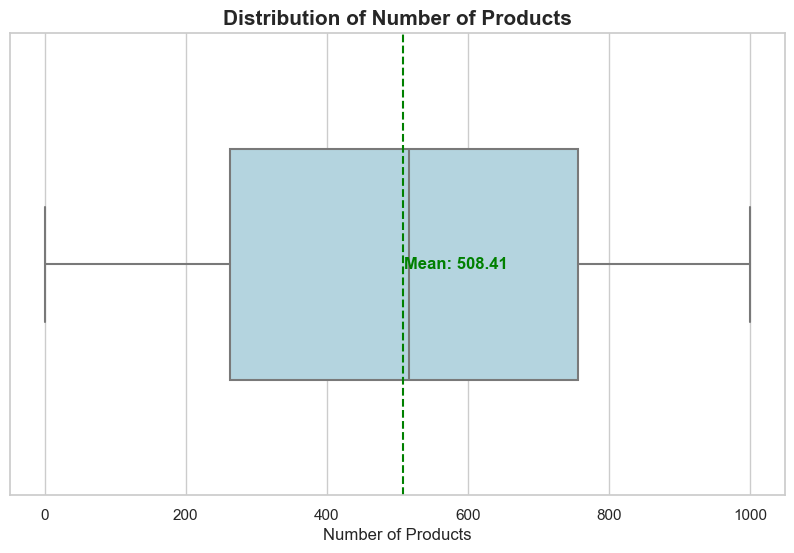

In [155]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['number_of_products_sold'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Number of Products', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Products', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['number_of_products_sold'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Revenue generated`

In [156]:
supply_chain_eda_df['revenue_generated'].describe()

count    1640.000000
mean     5588.976409
std      2557.628607
min      1016.190000
25%      3434.542500
50%      5648.785000
75%      7730.930000
max      9994.800000
Name: revenue_generated, dtype: float64

- The average revenue generated is approximately 5594.91 dollars.
- There is substantial variability in revenue, with a standard deviation of about 2569.75 dollars.
- The minimum revenue generated is 1016.19 dollars.
- 25% of the products generate revenue of 3403.43 dollars or less.
- The median revenue generated is 5640.64 dollars, indicating half of the products generate less than this amount.
- 75% of the products generate revenue of 7758.96 dollars or less.
- The maximum revenue generated is 9994.80 dollars.

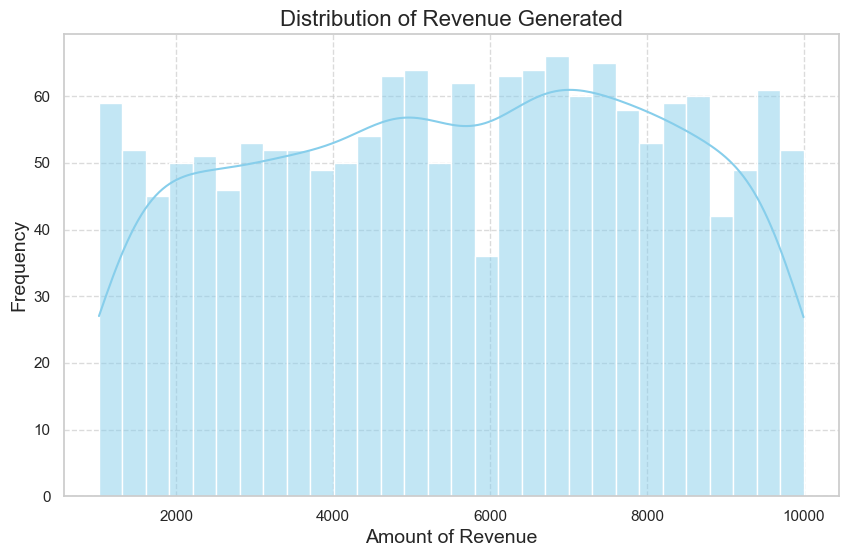

In [157]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['revenue_generated'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Revenue Generated', fontsize=16)
plt.xlabel('Amount of Revenue', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

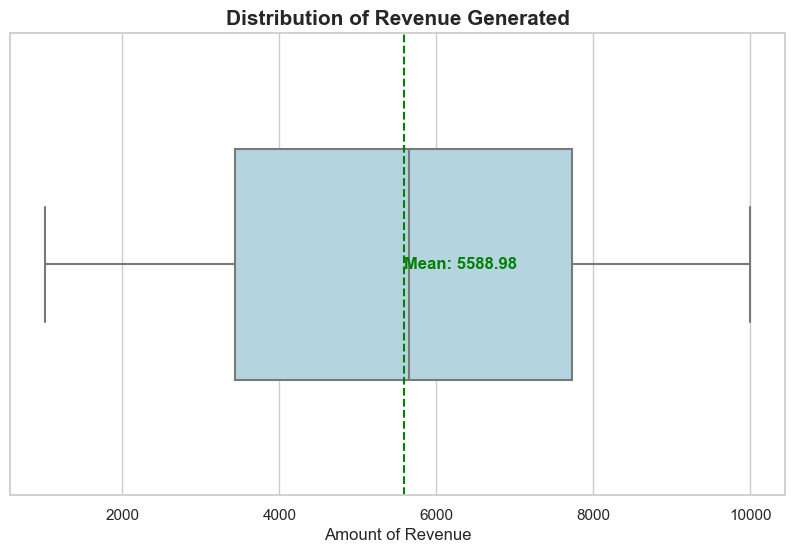

In [158]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['revenue_generated'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Revenue Generated', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Revenue', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['revenue_generated'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Stock levels`

In [159]:
supply_chain_eda_df['stock_levels'].describe()

count    1640.000000
mean       49.857317
std        28.882529
min         1.000000
25%        24.000000
50%        51.000000
75%        75.000000
max        99.000000
Name: stock_levels, dtype: float64

- The average stock level is approximately 49.98 units.
- Stock levels show high variability with a standard deviation of 28.68 units.
- The minimum stock level recorded is 1 unit.
- 25% of the products have stock levels of 25 units or less.
- The median stock level is 51 units, meaning half of the products have stock levels less than this amount.
- 75% of the products have stock levels of 75 units or less.
- The maximum stock level recorded is 99 units.

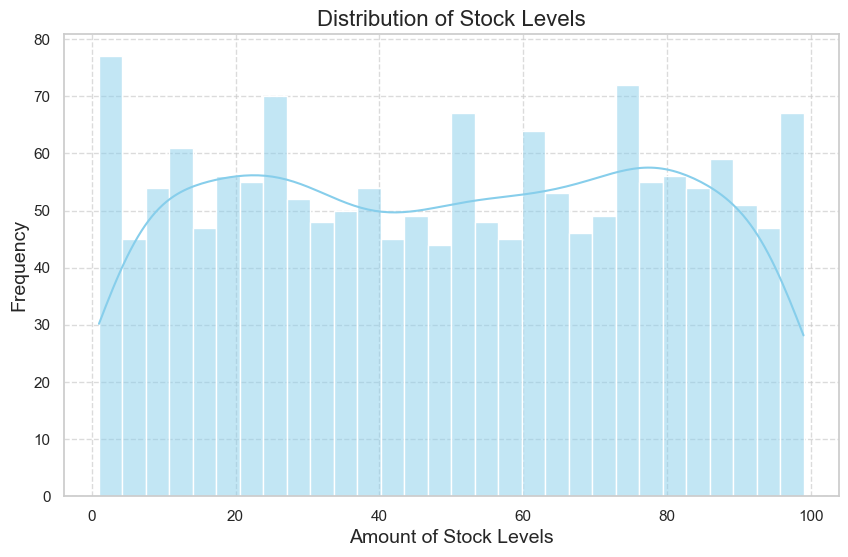

In [160]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['stock_levels'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Stock Levels', fontsize=16)
plt.xlabel('Amount of Stock Levels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

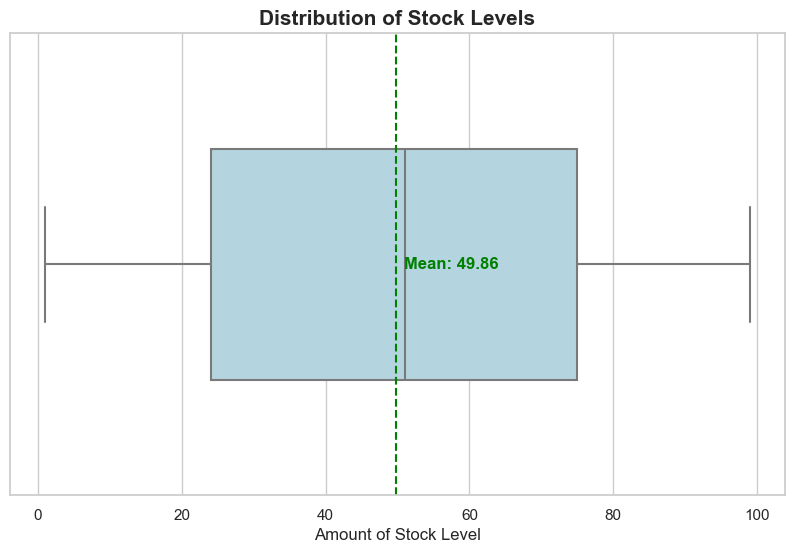

In [161]:
plt.figure(figsize=(10, 6))  
boxplot = sns.boxplot(x=supply_chain_eda_df['stock_levels'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Stock Levels', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Stock Level', fontsize=12)
boxplot.set_ylabel('')  

mean_price = supply_chain_eda_df['stock_levels'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Lead times`

In [162]:
supply_chain_eda_df['lead_times'].describe()

count    1640.000000
mean       14.736585
std         8.332702
min         1.000000
25%         7.000000
50%        15.000000
75%        22.000000
max        29.000000
Name: lead_times, dtype: float64

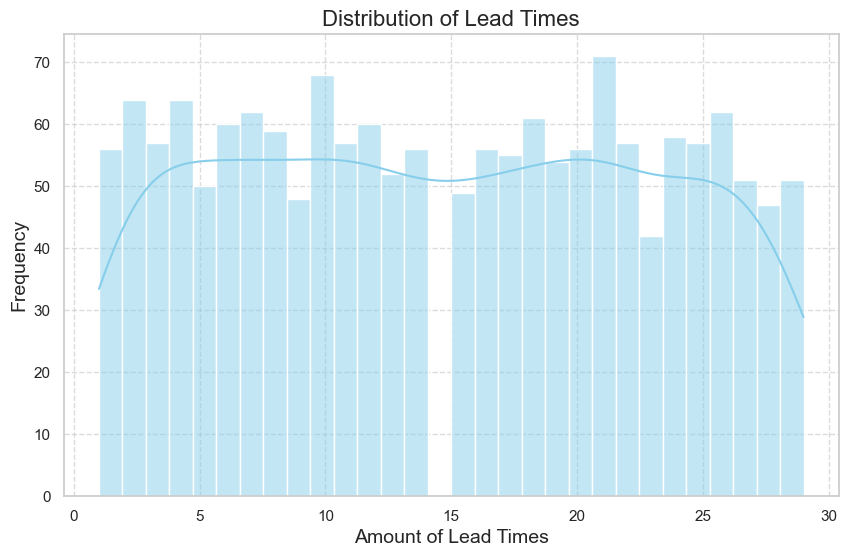

In [163]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['lead_times'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Lead Times', fontsize=16)
plt.xlabel('Amount of Lead Times', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

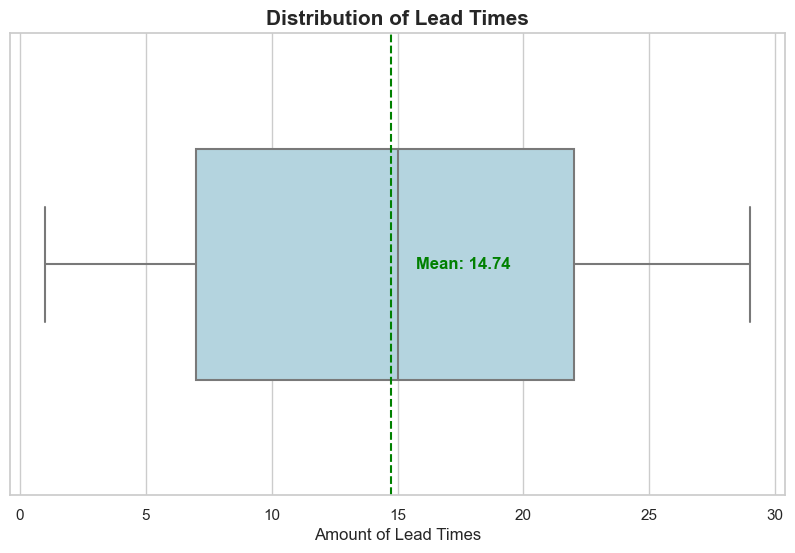

In [164]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['lead_times'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Lead Times', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Lead Times', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['lead_times'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Order quantities`

In [165]:
supply_chain_eda_df['order_quantities'].describe()

count    1640.000000
mean       49.860976
std        28.000352
min         1.000000
25%        26.000000
50%        50.000000
75%        74.250000
max        99.000000
Name: order_quantities, dtype: float64

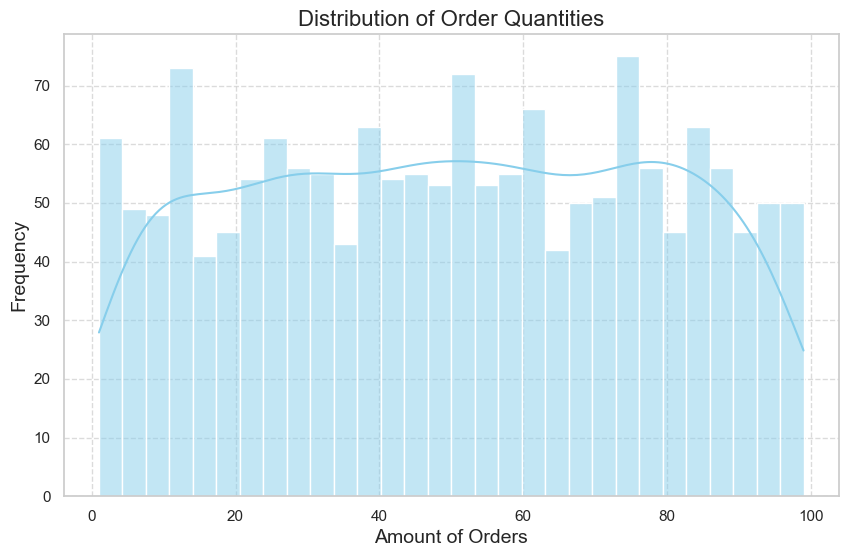

In [166]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['order_quantities'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Order Quantities', fontsize=16)
plt.xlabel('Amount of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

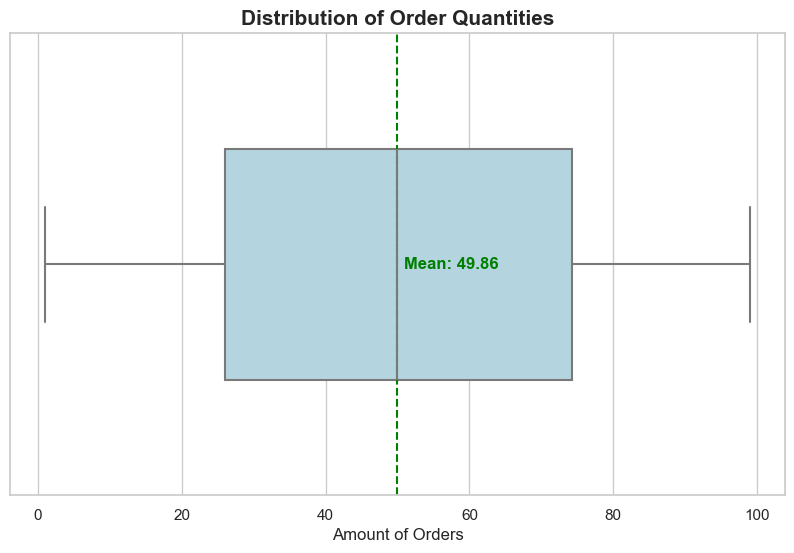

In [167]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['order_quantities'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Order Quantities', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Orders', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['order_quantities'].mean()
plt.axvline(mean_price, color='green', linestyle='--')  
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Shipping times`

In [168]:
supply_chain_eda_df['shipping_times'].describe()

count    1640.000000
mean        5.040854
std         2.563919
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: shipping_times, dtype: float64

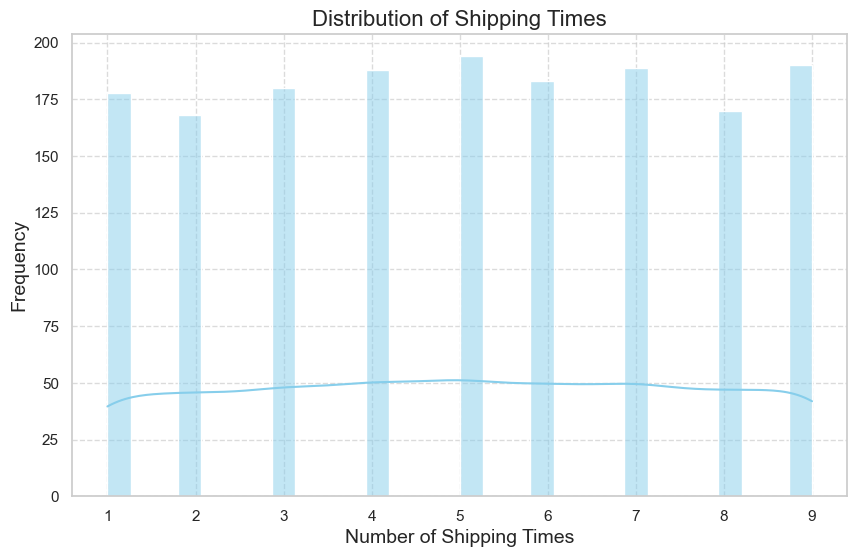

In [169]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['shipping_times'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Shipping Times', fontsize=16)
plt.xlabel('Number of Shipping Times', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

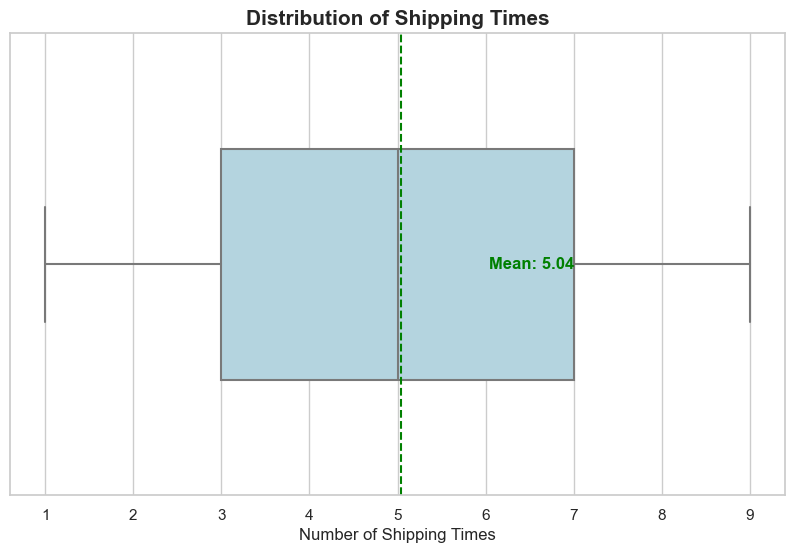

In [170]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['shipping_times'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Shipping Times', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Shipping Times', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['shipping_times'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Production volumes`

In [171]:
supply_chain_eda_df['production_volumes'].describe()

count    1640.000000
mean      533.719512
std       260.252418
min       100.000000
25%       307.750000
50%       525.000000
75%       762.000000
max       999.000000
Name: production_volumes, dtype: float64

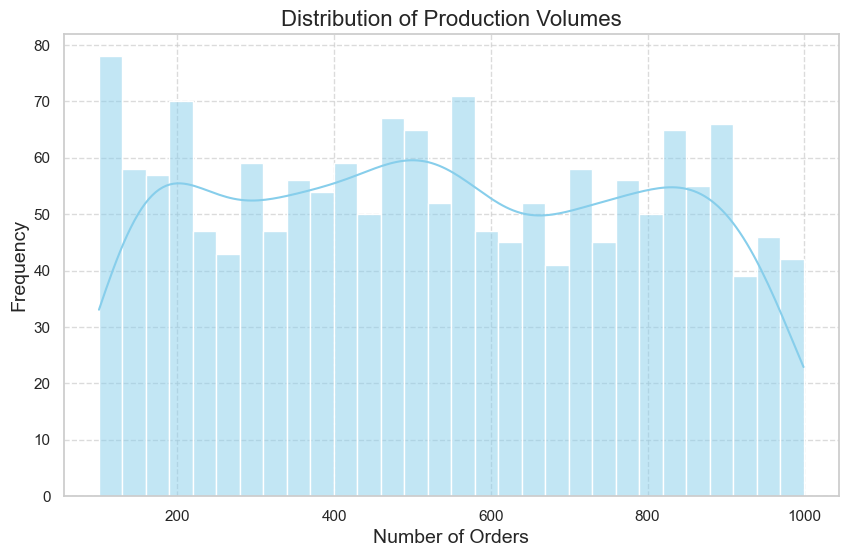

In [172]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['production_volumes'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Production Volumes', fontsize=16)
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

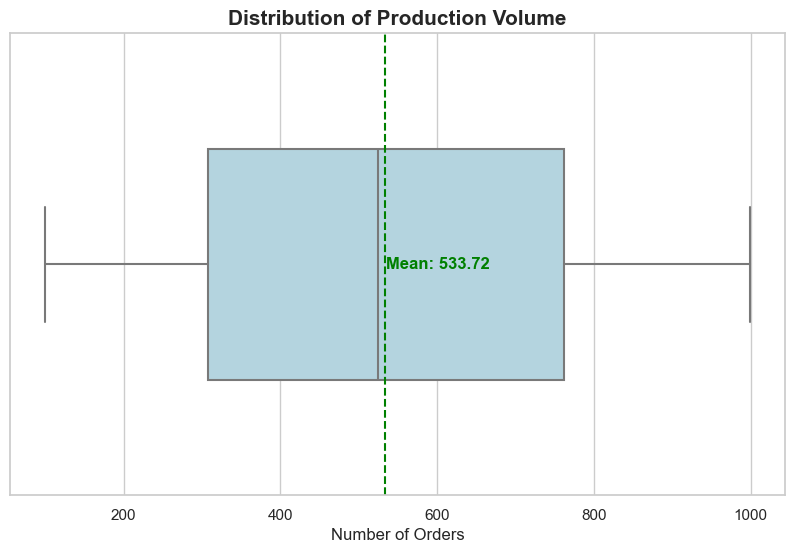

In [173]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['production_volumes'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Production Volume', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Number of Orders', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['production_volumes'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Manufacturing lead time`

In [174]:
supply_chain_eda_df['manufacturing_lead_time'].describe()

count    1640.000000
mean       15.184146
std         8.226076
min         1.000000
25%         8.000000
50%        15.000000
75%        22.000000
max        29.000000
Name: manufacturing_lead_time, dtype: float64

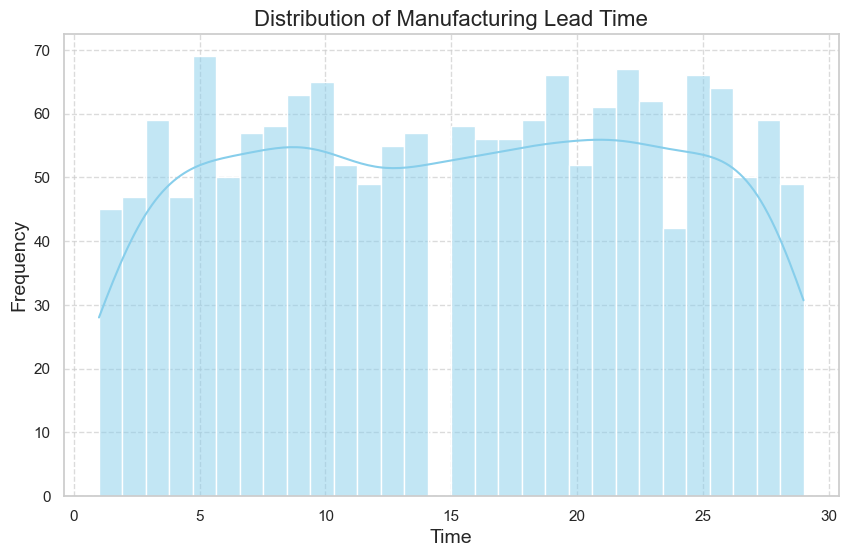

In [175]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['manufacturing_lead_time'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Manufacturing Lead Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

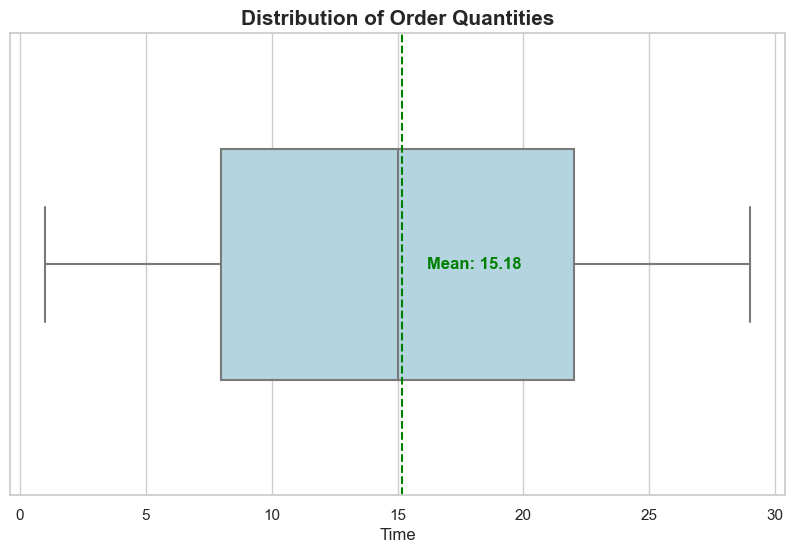

In [176]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['manufacturing_lead_time'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Order Quantities', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Time', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['manufacturing_lead_time'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Manufacturing costs`

In [177]:
supply_chain_eda_df['manufacturing_costs'].describe()

count    1640.000000
mean       55.442963
std        25.979000
min        10.000000
25%        32.740000
50%        55.770000
75%        77.985000
max        99.880000
Name: manufacturing_costs, dtype: float64

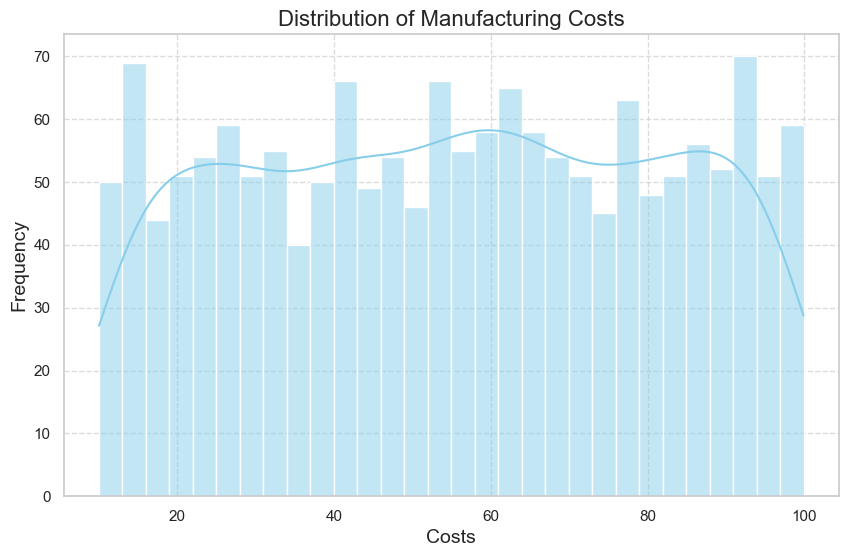

In [178]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['manufacturing_costs'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Manufacturing Costs', fontsize=16)
plt.xlabel('Costs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

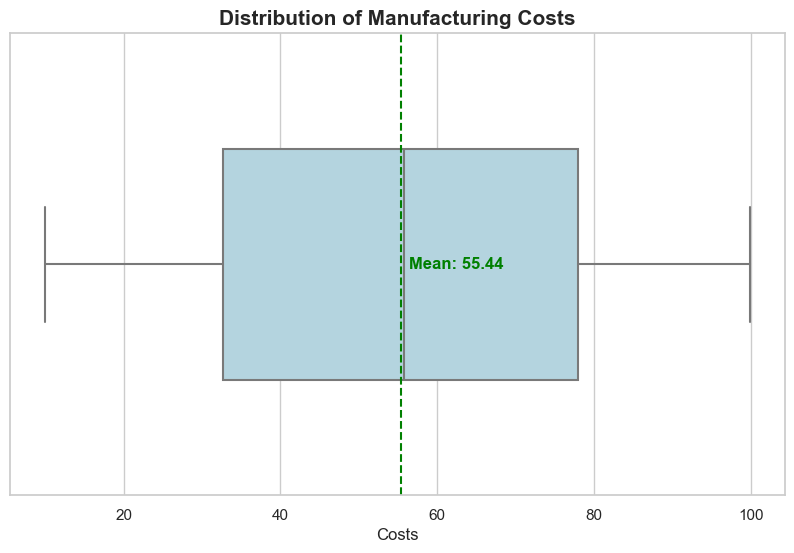

In [179]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['manufacturing_costs'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Manufacturing Costs', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Costs', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['manufacturing_costs'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Defect rates`

In [180]:
supply_chain_eda_df['defect_rates'].describe()

count    1640.000000
mean        2.515506
std         1.442442
min         0.000000
25%         1.290000
50%         2.515000
75%         3.790000
max         5.000000
Name: defect_rates, dtype: float64

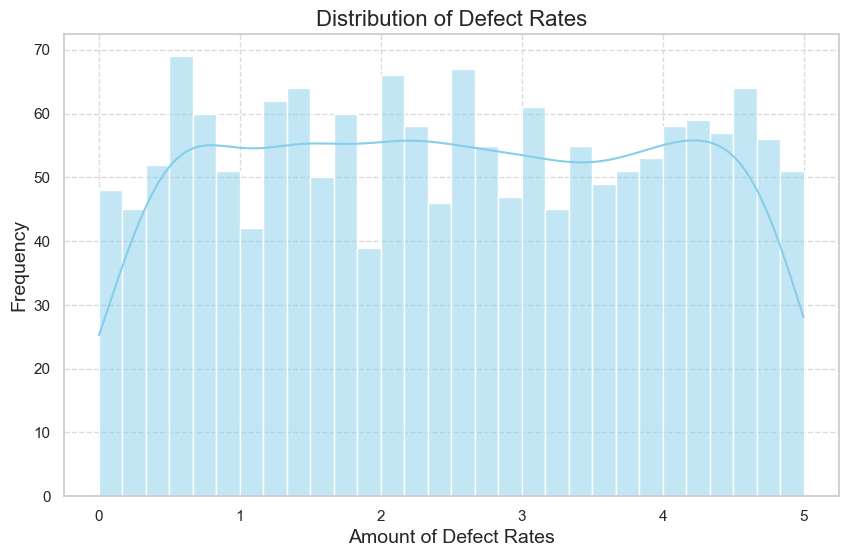

In [181]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['defect_rates'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Defect Rates', fontsize=16)
plt.xlabel('Amount of Defect Rates', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

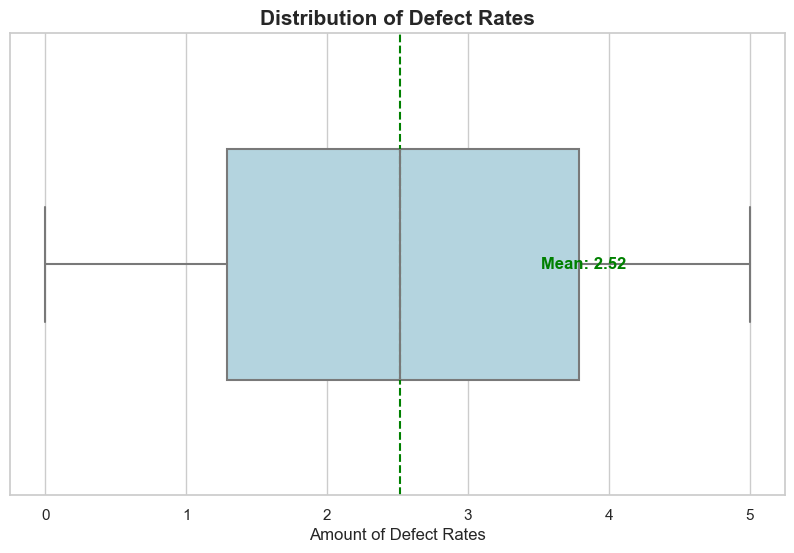

In [182]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['defect_rates'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Defect Rates', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Amount of Defect Rates', fontsize=12)
boxplot.set_ylabel('')

mean_price = supply_chain_eda_df['defect_rates'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Costs`

In [183]:
supply_chain_eda_df['costs'].describe()

count    1640.000000
mean      548.734707
std       258.641141
min       100.770000
25%       323.835000
50%       555.515000
75%       765.945000
max       998.960000
Name: costs, dtype: float64

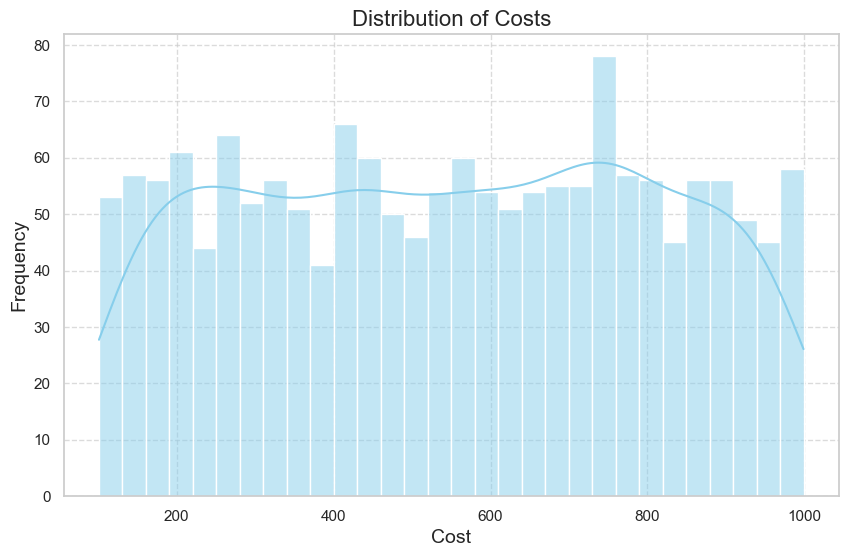

In [184]:
plt.figure(figsize=(10, 6))
sns.histplot(supply_chain_eda_df['costs'], bins=30, kde=True, color='skyblue')

plt.title('Distribution of Costs', fontsize=16)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

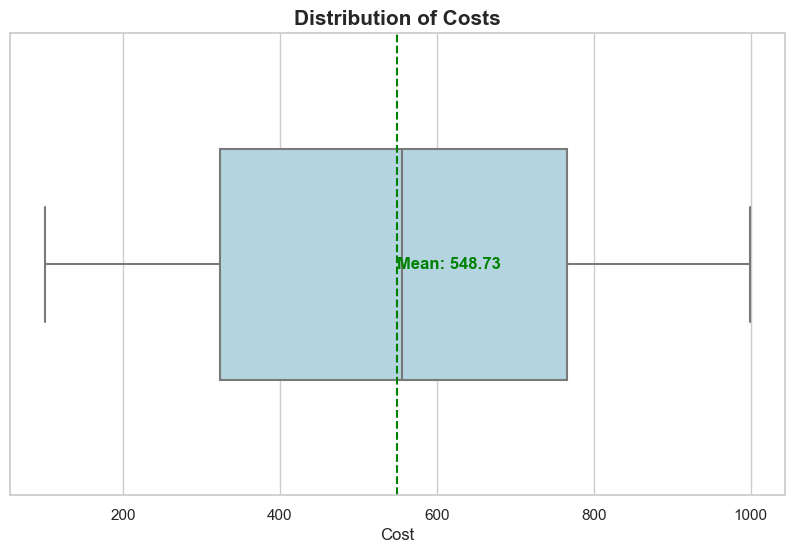

In [185]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=supply_chain_eda_df['costs'], color='lightblue', fliersize=5, width=0.5)

boxplot.set_title('Distribution of Costs', fontsize=15, fontweight='bold')
boxplot.set_xlabel('Cost', fontsize=12)
boxplot.set_ylabel('') 

mean_price = supply_chain_eda_df['costs'].mean()
plt.axvline(mean_price, color='green', linestyle='--')
plt.text(mean_price + 1, 0, f'Mean: {mean_price:.2f}', color='green', va='center', fontweight='bold')

plt.show()

---

`Estimated Price`

In [209]:
supply_chain_eda_df['estimated_price'].describe()

count     1640.000000
mean     50817.890244
std      28336.260812
min       1010.000000
25%      26017.500000
50%      51340.000000
75%      75067.500000
max      99990.000000
Name: estimated_price, dtype: float64

---

**Categorical columns:** [
    
    'Product type',
    'SKU',
    'Customer demographics',
    'Shipping carriers',
    'Supplier name',
    'Location',
    'Inspection results',
    'Transportation modes',
    'Routes'
]

---

`Product Type`

In [186]:
unique_values_counts = supply_chain_eda_df['product_type'].value_counts()
print(unique_values_counts)

product_type
haircare     563
skincare     550
cosmetics    527
Name: count, dtype: int64


  Product Type  Frequency
0     haircare        563
1     skincare        550
2    cosmetics        527


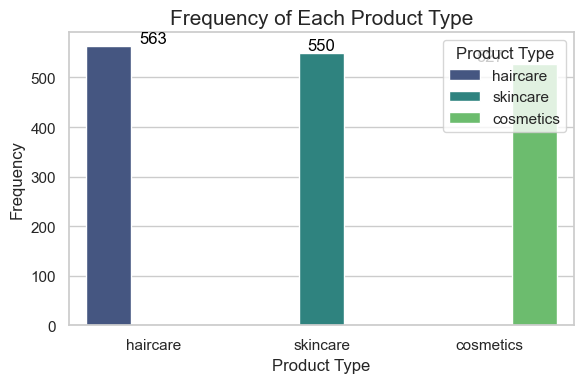

In [187]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Product Type', 'Frequency']

print(unique_values_counts_df)

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='Product Type', y='Frequency',hue='Product Type', data=unique_values_counts_df,palette='viridis')

barplot.set_title('Frequency of Each Product Type', fontsize=15)
barplot.set_xlabel('Product Type', fontsize=12)
barplot.set_ylabel('Frequency', fontsize=12)

for index, row in unique_values_counts_df.iterrows():
    barplot.text(row.name, row.Frequency, row.Frequency, color='black', ha="center", va="bottom")

plt.tight_layout()
plt.show()

---

`SKU`

In [188]:
unique_values_counts = supply_chain_eda_df['sku'].value_counts()
print(unique_values_counts)

sku
062000007          1
GR431000           1
OT0554             1
NJ2943             1
WE107149           1
                  ..
C816403-0001/01    1
C816410-0001/01    1
C819215-1689/00    1
C819209-48360/0    1
CHNI013            1
Name: count, Length: 1640, dtype: int64


In [189]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['SKU', 'Frequency']

print(unique_values_counts_df)

                  SKU  Frequency
0           062000007          1
1            GR431000          1
2              OT0554          1
3              NJ2943          1
4            WE107149          1
...               ...        ...
1635  C816403-0001/01          1
1636  C816410-0001/01          1
1637  C819215-1689/00          1
1638  C819209-48360/0          1
1639          CHNI013          1

[1640 rows x 2 columns]


---

`Customer Demographics`

In [190]:
unique_values_counts = supply_chain_eda_df['customer_demographics'].value_counts()
print(unique_values_counts)

customer_demographics
Male          473
Unknown       407
Non-binary    402
Female        358
Name: count, dtype: int64


In [191]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Customer Demographics', 'Frequency']

print(unique_values_counts_df)

  Customer Demographics  Frequency
0                  Male        473
1               Unknown        407
2            Non-binary        402
3                Female        358


---

`Shipping carriers`

In [192]:
unique_values_counts = supply_chain_eda_df['shipping_carriers'].value_counts()
print(unique_values_counts)

shipping_carriers
Carrier A    565
Carrier B    551
Carrier C    524
Name: count, dtype: int64


In [193]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Shipping carriers', 'Frequency']

print(unique_values_counts_df)

  Shipping carriers  Frequency
0         Carrier A        565
1         Carrier B        551
2         Carrier C        524


---

`Supplier name`

In [194]:
unique_values_counts = supply_chain_eda_df['supplier_name'].value_counts()
print(unique_values_counts)

supplier_name
Supplier 3    360
Supplier 1    334
Supplier 4    325
Supplier 2    312
Supplier 5    309
Name: count, dtype: int64


In [195]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Supplier Name', 'Frequency']

print(unique_values_counts_df)

  Supplier Name  Frequency
0    Supplier 3        360
1    Supplier 1        334
2    Supplier 4        325
3    Supplier 2        312
4    Supplier 5        309


---

`Location`

In [196]:
unique_values_counts = supply_chain_eda_df['location'].value_counts()
print(unique_values_counts)

location
Delhi        339
Bangalore    337
Mumbai       336
Chennai      328
Kolkata      300
Name: count, dtype: int64


In [197]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Location', 'Frequency']

print(unique_values_counts_df)

    Location  Frequency
0      Delhi        339
1  Bangalore        337
2     Mumbai        336
3    Chennai        328
4    Kolkata        300


---

`Inspection results`

In [198]:
unique_values_counts = supply_chain_eda_df['inspection_results'].value_counts()
print(unique_values_counts)

inspection_results
Pass       568
Fail       545
Pending    527
Name: count, dtype: int64


In [199]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Inspection Results', 'Frequency']

print(unique_values_counts_df)

  Inspection Results  Frequency
0               Pass        568
1               Fail        545
2            Pending        527


---

`Transportation modes`

In [200]:
unique_values_counts = supply_chain_eda_df['transportation_modes'].value_counts()
print(unique_values_counts)

transportation_modes
Sea     426
Air     417
Rail    410
Road    387
Name: count, dtype: int64


In [201]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Transportation Modes', 'Frequency']

print(unique_values_counts_df)

  Transportation Modes  Frequency
0                  Sea        426
1                  Air        417
2                 Rail        410
3                 Road        387


---

`Routes`

In [202]:
unique_values_counts = supply_chain_eda_df['routes'].value_counts()
print(unique_values_counts)

routes
Route_B    573
Route_A    572
Route_C    495
Name: count, dtype: int64


In [203]:
unique_values_counts_df = unique_values_counts.reset_index()
unique_values_counts_df.columns = ['Routes', 'Frequency']

print(unique_values_counts_df)

    Routes  Frequency
0  Route_B        573
1  Route_A        572
2  Route_C        495


---

### Multivariate Analysis

**Data Distributions**

In [204]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

In [205]:
numeric_features.columns

Index(['estimated_price', 'availability', 'number_of_products_sold',
       'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities',
       'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes',
       'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates',
       'costs', 'demurrage'],
      dtype='object')

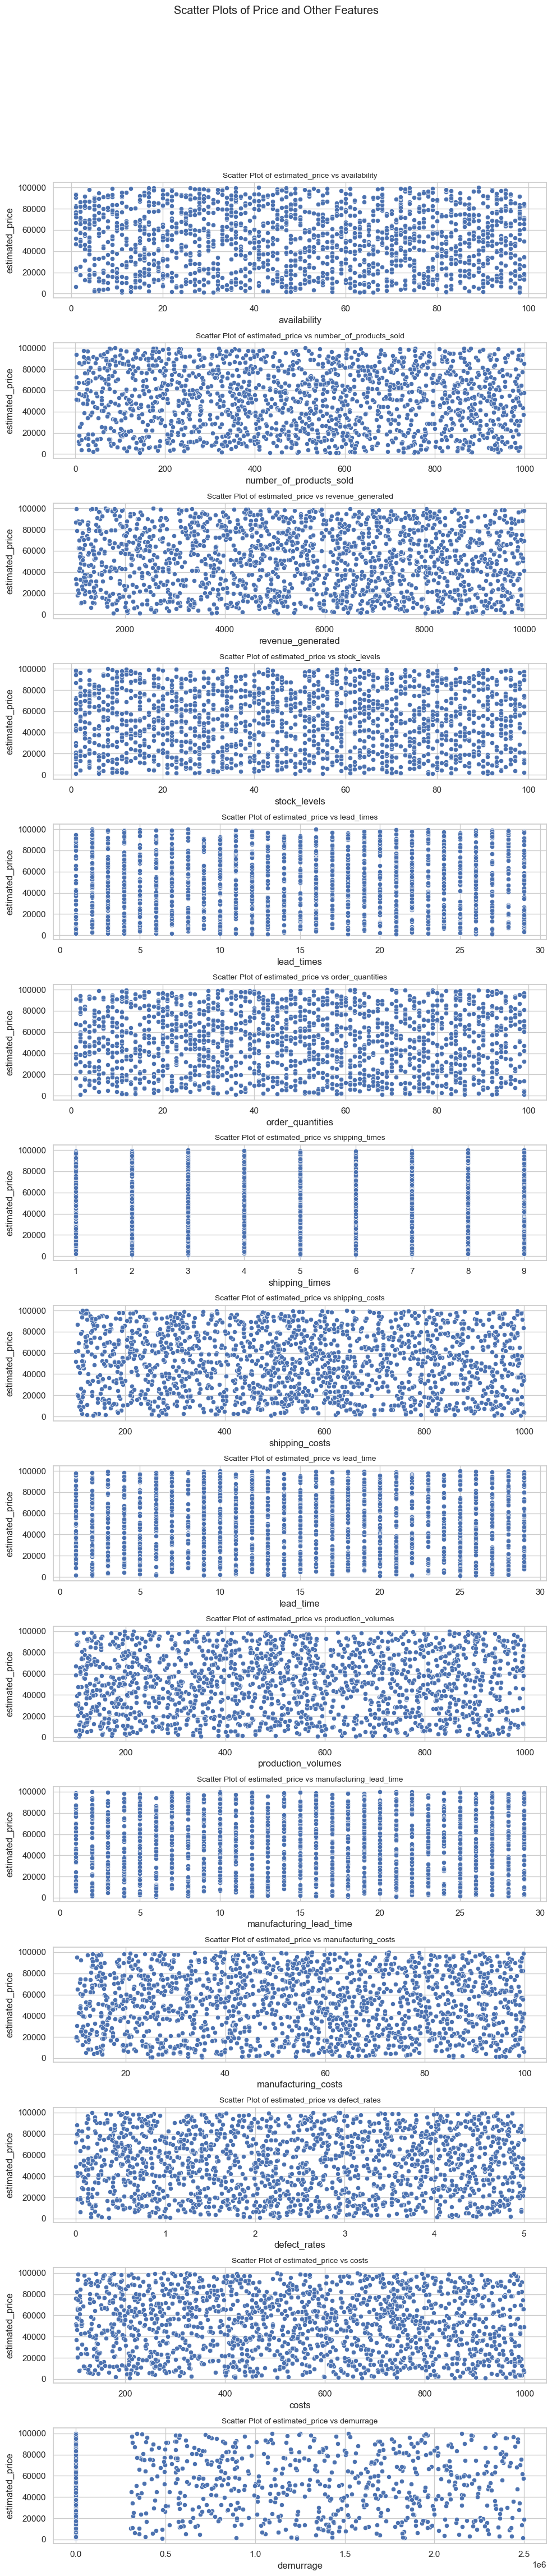

In [206]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

target = 'estimated_price'
variables = numeric_features.columns.drop(target)

fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(10, len(variables) * 3))

for i, var in enumerate(variables):
    sns.scatterplot(x=numeric_features[var], y=numeric_features[target], ax=axes[i])
    axes[i].set_title(f'Scatter Plot of {target} vs {var}', fontsize=10)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(target)

plt.tight_layout()
fig.suptitle('Scatter Plots of Price and Other Features', y=1.02)
plt.subplots_adjust(top=0.95)
plt.show()


---

**Correlation Matrix**

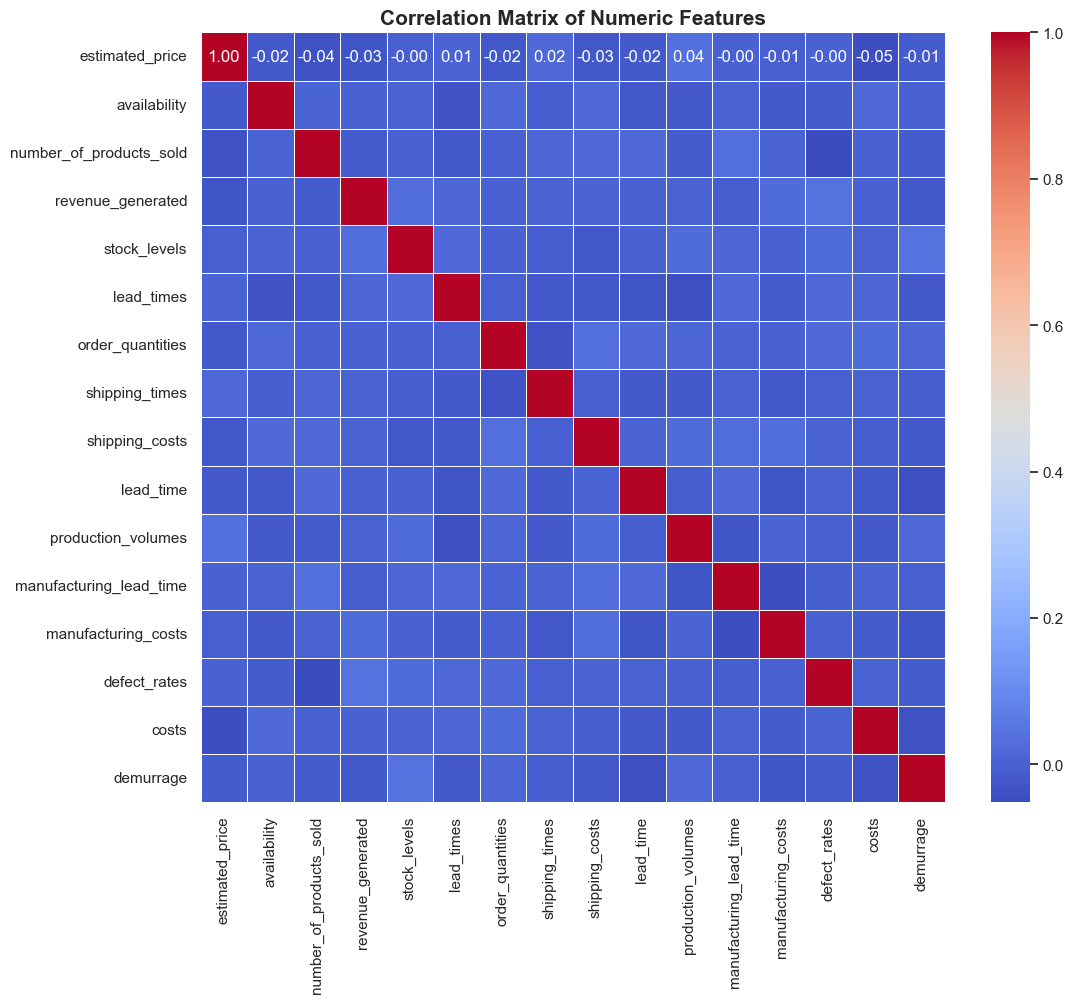

In [207]:
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

heatmap.set_title('Correlation Matrix of Numeric Features', fontsize=15, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

- Price has a low correlation with all other variables, indicating that price changes do not significantly affect other features or vice versa. (No strong linear regression)
- Availability ,Lead times ,Shipping timesshows very low correlation with other features, suggesting that the availability of products is relatively independent of other features.
- The only notable correlation is between the number of products sold and revenue generated (r=0.33), which aligns with expectations as sales volume typically drives revenue.

---

**Multicollinearity**

In [208]:
numeric_features = supply_chain_eda_df.select_dtypes(include=['int64', 'float64'])

X = add_constant(numeric_features)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature        VIF
0                     const  58.401782
1           estimated_price   1.007960
2              availability   1.003922
3   number_of_products_sold   1.006658
4         revenue_generated   1.004840
5              stock_levels   1.004983
6                lead_times   1.006607
7          order_quantities   1.004330
8            shipping_times   1.003328
9            shipping_costs   1.006448
10                lead_time   1.006223
11       production_volumes   1.006696
12  manufacturing_lead_time   1.005685
13      manufacturing_costs   1.006758
14             defect_rates   1.006021
15                    costs   1.005389
16                demurrage   1.008272


- All features have VIF values close to 1, indicating that there is very low multicollinearity among them.